# Random Number Generators for Monte Carlo (Julia)

Monte Carlo methods rely completely on the quality of random numbers.  
In real physics applications (Ising models, path integrals, diffusion processes, finance, etc.), we almost always use **pseudo–random number generators (PRNGs)**: deterministic algorithms that aim to mimic independent, uniformly distributed random variables.

The idea is simple:

- Internally, the generator keeps a **state** (usually an integer or vector of integers).
- At each step, it updates the state and outputs a number in $(0,1)$.
- The sequence should *look* statistically like independent uniform random numbers.

We never get truly random numbers from a deterministic algorithm, but we can require:

- Approximately uniform distribution on $[0,1)$.
- Very long **period** (the sequence does not repeat within the simulation time).
- Weak autocorrelations between successive values.
- Reasonable performance in basic statistical tests (moments, correlation, etc.).

In this notebook we will:

1. Implement and study three PRNGs:
   - Linear Congruential Generator (LCG),
   - Shuffled LCG (Bays–Durham shuffle),
   - Lagged Fibonacci Generator (LFG).
2. Test their quality using:
   - Moments $\langle r^n\rangle$ for $n=1,2,3$,
   - Autocorrelations $\langle(r_i - \tfrac12)(r_{i+k} - \tfrac12)\rangle$ for $k=1,2,3$.
3. Use the LFG to perform **importance–sampling Monte Carlo integration**.

---

## 1. Pseudo–Random Numbers and the Role of the Seed

Consider a discrete dynamical system

$$
x_n = f(x_{n-1}),\quad n=1,2,\dots
$$

with initial condition $x_0$ (the **seed**). For PRNGs:

- $x_n$ is typically an integer in $\{0,1,\dots,m-1\}$,
- The output random number is
  $$
  r_n = \frac{x_n}{m} \in [0,1).
  $$

Because the mapping $f$ and the seed $x_0$ are fully deterministic, the entire sequence is determined. But if $f$ is chosen well, the sequence can be *statistically indistinguishable* from independent uniform samples for the purposes of our simulation.

Two key concepts:

- **Seed** $x_0$: controls the particular realization. Different seeds give different sequences.
- **Period**: the smallest $P$ such that $x_{n+P} = x_n$ for all $n$ beyond some point. Ideally, $P$ is so large that we never hit the repetition regime in practice.

---

## 2. Linear Congruential Generator (LCG)

### 2.1 Definition

The Linear Congruential Generator is one of the simplest and historically most widely used PRNGs. It is defined by

$$
x_{n+1} = (a x_n + c) \bmod m,
$$

with integer constants:

- $m$ = modulus,
- $a$ = multiplier,
- $c$ = increment,

and state $x_n \in \{0,\dots,m-1\}$. The corresponding random number is

$$
r_n = \frac{x_n}{m} \in [0,1).
$$

In many applications we use the **multiplicative LCG** with $c=0$:

$$
x_{n+1} = (a x_n)\bmod m.
$$

If we choose the parameters $(a,c,m)$ carefully, the generator can have full period $m$ and reasonably good one–dimensional statistics.

### 2.2 Advantages and limitations

**Advantages:**
- Extremely fast (just a multiply, add, and mod).
- Very simple to implement and port.
- Historically used in many legacy codes.

**Limitations:**
- Correlations between successive values.
- In higher dimensions, points $(r_i, r_{i+1}, r_{i+2},\dots)$ lie on a finite number of hyperplanes.
- Lower bits may have very poor randomness.
- Period is at most $m$ (often around $2^{31}$ or $2^{32}$), which is not enough for extremely long simulations.

Because of these limitations, LCGs are often improved by **shuffling** or replaced by more sophisticated generators.

---

## 3. Shuffled LCG (Bays–Durham Shuffle)

### 3.1 Motivation

The LCG remembers only the previous state $x_{n-1}$; the mapping is strictly first–order:

$$
x_{n} = f(x_{n-1}).
$$

This gives the generator a **very short memory** and leads to strong serial correlations.

A simple way to improve the generator is to introduce a **table of past values** and use a *shuffling* procedure to select outputs from this table, updating it along the way.

The Bays–Durham shuffle is a classic method that significantly improves the statistical quality of an underlying generator like an LCG.

### 3.2 Bays–Durham shuffle algorithm

1. Choose a table size $L$ (for example, $L \sim 32$–$128$).
2. Use the base LCG to generate $L$ initial values:
   $$
   u_1, u_2, \dots, u_L \sim \text{LCG}.
   $$
3. Also generate an extra value $y \in (0,1)$ for indexing.
4. To get each new random number:
   1. Compute an integer index
      $$
      j = \lfloor L y \rfloor + 1, \quad j \in \{1,\dots,L\}.
      $$
   2. Output $u_j$ as the random number.
   3. Update $y \leftarrow u_j$.
   4. Replace $u_j$ with a fresh value from the base LCG.

This effectively turns the single–step LCG into a generator with a **buffer of length $L$**, leading to:

- Longer effective memory,
- Reduced serial correlations,
- Improved statistical properties.

---

## 4. Lagged Fibonacci Generator (LFG)

The Lagged Fibonacci Generator uses a recurrence with two different lags:

$$
x_n = (x_{n-r} \,\oplus\, x_{n-s}) \bmod m,
$$

where $\oplus$ is an operation (often addition, subtraction, multiplication, or XOR), and $r,s$ are positive integers with $s > r$.

In this notebook we will consider the **multiplicative** LFG with

- lags $r = 24$, $s = 55$,
- modulus $m = 2^{31} - 1$,
- and
  $$
  x_n = (x_{n-24} x_{n-55}) \bmod m,
  \quad
  r_n = \frac{x_n}{m}.
  $$

### 4.1 Initialization and properties

We must seed the first $s$ entries $x_1,\dots,x_s$. A common strategy:

- Use an LCG to generate $s$ initial values,
- Then start the LFG recurrence for $n > s$.

**Properties:**

- The effective period is extremely large (typically many orders of magnitude beyond a simple LCG).
- The use of two lags introduces a kind of “long–range memory” that suppresses short–range correlations.
- With appropriate parameters, LFGs pass many non-trivial statistical tests and are widely used in scientific computing.

---

## 5. Testing RNG Quality: Moments and Autocorrelations

For an ideal Uniform$(0,1)$ random variable $r$:

1. The moments satisfy
   $$
   \mathbb{E}[r^n] = \int_0^1 r^n\,dr = \frac{1}{n+1}.
   $$
   So we expect
   $$
   \langle r \rangle \approx \frac{1}{2},\quad
   \langle r^2 \rangle \approx \frac{1}{3},\quad
   \langle r^3 \rangle \approx \frac{1}{4}.
   $$

2. The autocorrelation at lag $k$ should vanish:
   $$
   C_k = \left\langle (r_i - \tfrac12)(r_{i+k} - \tfrac12)\right\rangle \approx 0,
   $$
   for any fixed $k \ge 1$.

In practice we approximate these expectations with finite–sample averages. For a sequence $\{r_i\}_{i=1}^N$:

- Empirical moment:
  $$
  \hat{m}_n = \frac{1}{N} \sum_{i=1}^N r_i^n.
  $$
- Empirical autocorrelation:
  $$
  \hat{C}_k = \frac{1}{N-k}\sum_{i=1}^{N-k} (r_i - \tfrac12)(r_{i+k} - \tfrac12).
  $$

Deviations of $\hat{m}_n$ from $1/(n+1)$ and $\hat{C}_k$ from $0$ give an indication of the generator quality.

We will compute these diagnostics for LCG, Shuffled LCG, and LFG, and visualize the results with histograms and bar plots.

---

## 6. From Uniform to Other Distributions: Transformation Method

Our PRNGs produce $r \sim U(0,1)$. Often we need to sample from more interesting distributions $g(z)$.

Given a normalized probability density function $g(z)$ with cumulative distribution

$$
G(z) = \int_{-\infty}^z g(z')\,dz',
$$

we can generate $z$ from $g$ by:

1. Draw $r \sim U(0,1)$,
2. Set $z = G^{-1}(r)$.

This is the **inverse transform (transformation) method**. Some examples:

- Uniform on $[a,b)$:
  $$
  z = a + (b-a)r.
  $$
- Exponential with rate $a>0$:
  $$
  g(z)=a e^{-a z},\quad z\ge 0 \quad\Rightarrow\quad z = -\frac{1}{a}\ln(1-r).
  $$

When $G^{-1}$ is not available in closed form (e.g. Gaussian), we need other methods such as Box–Muller, rejection sampling, or more advanced techniques.

---

## 7. Importance Sampling Monte Carlo Integrals

Consider an integral

$$
I = \int_a^b g(z)\,dz.
$$

If we can sample $z$ from a normalized density $g_0(z)$, and we know

$$
I_0 = \int_a^b g_0(z)\,dz,
$$

then we can write

$$
I = \int_a^b g(z)\,dz
= I_0 \int_a^b \frac{g(z)}{g_0(z)} \frac{g_0(z)}{I_0}\,dz
= I_0\,\mathbb{E}_{g_0}\!\left[\frac{g(z)}{g_0(z)}\right].
$$

A simple Monte Carlo estimator is

$$
I \approx I_0\cdot \frac{1}{N} \sum_{i=1}^N \frac{g(z_i)}{g_0(z_i)},
\quad z_i \sim g_0(z).
$$

A common and convenient choice is $g_0(z)=e^{-z}$ on $[0,\infty)$, for which $I_0 = 1$ and we can sample $z$ via

$$
z = -\ln(1-r),\quad r\sim U(0,1).
$$

In this notebook we will consider integrals of the form

$$
I_1 = \int_0^\infty \frac{\sin^2 z}{z \sinh z}\,dz,
\qquad
I_2 = \int_0^\infty \frac{\sin z}{z \cosh z}\,dz,
$$

and estimate them with importance sampling using the Lagged Fibonacci generator to produce the uniform random numbers.

---

In [1]:
using Statistics
using Plots

In [1]:
# Linear Congruential Generator (LCG) implementation

# Store the parameters and state
mutable struct LCG
    state::Int64  # current integer state
    a::Int64      # multiplier
    m::Int64      # modulus
end

# Constructor with default parameters
LCG(seed::Int=123456789; a::Int=17869, m::Int=Int(2^31 - 1)) =
    LCG(mod(seed, m), a, m)

# Generate one uniform(0,1) random number and update the state
function rand_lcg!(rng::LCG)
    rng.state = (rng.state * rng.a) % rng.m
    return rng.state / rng.m
end

# Generate a vector of n random numbers
function lcg_sequence(n::Int; seed::Int=1234)
    rng = LCG(seed)
    out = Vector{Float64}(undef, n)
    @inbounds for i in 1:n
        out[i] = rand_lcg!(rng)
    end
    return out
end

# quick smoke test
lcg_vals = lcg_sequence(10_000)
println("LCG: first 5 values = ", lcg_vals[1:5])

LCG: first 5 values = [0.010267992508722465, 0.47875813836173997, 0.9291743859318897, 0.41710221693716115, 0.19951445013262073]


In [2]:
# Bays–Durham Shuffle RNG built on top of LCG

function shuffle_rng(n::Int; table_len::Int=100, seed::Int=1234)
    rng = LCG(seed)
    # Initialize a table of past values
    table = [rand_lcg!(rng) for _ in 1:table_len]

    # y is used to select indices in the table
    y = rand_lcg!(rng)

    out = Vector{Float64}(undef, n)

    @inbounds for i in 1:n
        # Convert y in (0,1) into an index 1..table_len
        j = clamp(floor(Int, y * table_len) + 1, 1, table_len)

        # Output the selected table entry
        out[i] = table[j]

        # Feedback: next y is this table value
        y = table[j]

        # Replace table[j] by a fresh value from the LCG
        table[j] = rand_lcg!(rng)
    end

    return out
end

shuf_vals = shuffle_rng(10_000)
println("Shuffle RNG: first 5 values = ", shuf_vals[1:5])

Shuffle RNG: first 5 values = [0.807263942345634, 0.9791460414319979, 0.9575325371499791, 0.2913307069294763, 0.15336508357588438]


In [3]:
# Lagged Fibonacci Generator (multiplicative, lags 24 and 55)
# We seed the first 55 integers using the LCG, then apply:
#   x_n = (x_{n-24} * x_{n-55}) mod m

function lfg_sequence(n::Int; r::Int=24, s::Int=55, seed::Int=1234)
    @assert 1 ≤ r < s "Need 1 ≤ r < s"

    m = Int(2^31 - 1)
    a = 17869
    base = LCG(seed; a=a, m=m)

    # Seed the first s integers using LCG
    buf = Vector{Int}(undef, s + n)
    for i in 1:s
        buf[i] = Int(floor(rand_lcg!(base) * m))
    end

    # Recurrence: fill buf[s+1],...,buf[s+n]
    @inbounds for i in (s+1):(s+n)
        buf[i] = (buf[i - r] * buf[i - s]) % m
    end

    # Convert the last n entries to uniform(0,1)
    out = Vector{Float64}(undef, n)
    @inbounds for i in 1:n
        out[i] = buf[s + i] / m
    end

    return out
end

lfg_vals = lfg_sequence(10_000)
println("LFG: first 5 values = ", lfg_vals[1:5])

LFG: first 5 values = [0.19485141625388125, 0.4323585561627329, 0.9510443238313516, 0.7618105419733611, 0.5141334196152787]


In [4]:
using Statistics

# Compute autocorrelations C_k for k = 1..maxlag
function autocorrelations(r::Vector{Float64}, maxlag::Int=3)
    N = length(r)
    C = zeros(Float64, maxlag)
    @inbounds for k in 1:maxlag
        s = 0.0
        for i in 1:(N-k)
            s += (r[i] - 0.5) * (r[i+k] - 0.5)
        end
        C[k] = s / (N - k)
    end
    return C
end

# Compute moments <r^n> and RMS deviations from 1/(n+1)
function raw_moments_with_error(r::Vector{Float64}; pows=(1,2,3))
    N = length(r)
    moments = zeros(Float64, length(pows))
    errors  = zeros(Float64, length(pows))

    @inbounds for (ix, n) in enumerate(pows)
        vals = r .^ n
        m = mean(vals)
        target = 1 / (n + 1)
        err = sqrt(mean((vals .- target).^2))

        moments[ix] = m
        errors[ix]  = err
    end

    return moments, errors
end

# Compare the three generators on a long sequence
N = 200_000
lcg_vals  = lcg_sequence(N)
shuf_vals = shuffle_rng(N)
lfg_vals  = lfg_sequence(N)

println("Autocorrelations C_k (k=1..3):")
println("  LCG     → ", autocorrelations(lcg_vals))
println("  Shuffle → ", autocorrelations(shuf_vals))
println("  LFG     → ", autocorrelations(lfg_vals))

println("\nMoments <r^n> and RMS error for n=1,2,3:")
println("  LCG     → ", raw_moments_with_error(lcg_vals))
println("  Shuffle → ", raw_moments_with_error(shuf_vals))
println("  LFG     → ", raw_moments_with_error(lfg_vals))

Autocorrelations C_k (k=1..3):
  LCG     → [0.00031299493916261023, 5.20604776450916e-5, 6.396206871770146e-5]
  Shuffle → [0.0003577968487532767, -0.00018887822084419812, -0.0002807735504442419]
  LFG     → [0.000299424356490923, 0.00012110555106257585, -6.200705276215313e-5]

Moments <r^n> and RMS error for n=1,2,3:
  LCG     → ([0.5002359161430205, 0.3334473928356898, 0.25004751295948585], [0.2884639954875986, 0.2980338342567833, 0.28339239448584225])
  Shuffle → ([0.5002257383285373, 0.3334338659325925, 0.2500329578273972], [0.28845819039170173, 0.29802451074236075, 0.28338139526086015])
  LFG     → ([0.5001961773728026, 0.33352023923012375, 0.2501698823304879], [0.28865907548061115, 0.29818875067579254, 0.28355262928033537])


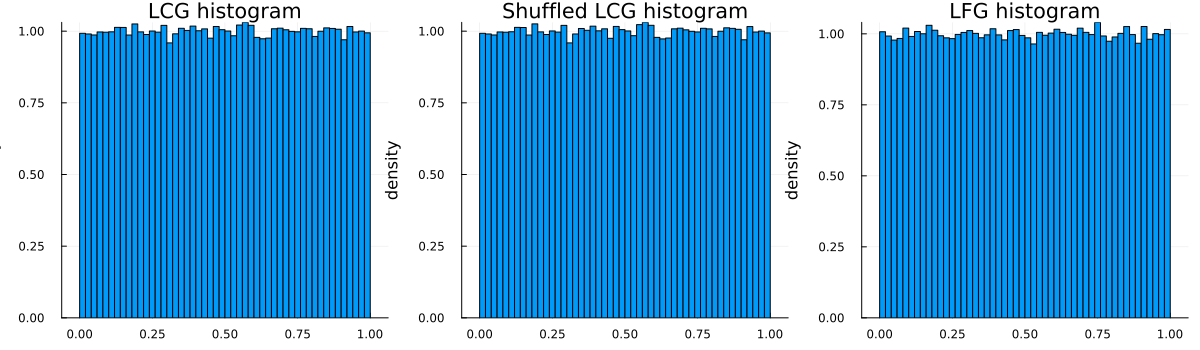

In [5]:
using Plots

# Histograms of each generator (visually check uniformity)
p_lcg = histogram(lcg_vals; bins=50, normalize=true,
                  xlabel="r", ylabel="density",
                  title="LCG histogram", legend=false)

p_shf = histogram(shuf_vals; bins=50, normalize=true,
                  xlabel="r", ylabel="density",
                  title="Shuffled LCG histogram", legend=false)

p_lfg = histogram(lfg_vals; bins=50, normalize=true,
                  xlabel="r", ylabel="density",
                  title="LFG histogram", legend=false)

plot(p_lcg, p_shf, p_lfg; layout=(1,3), size=(1200, 350))

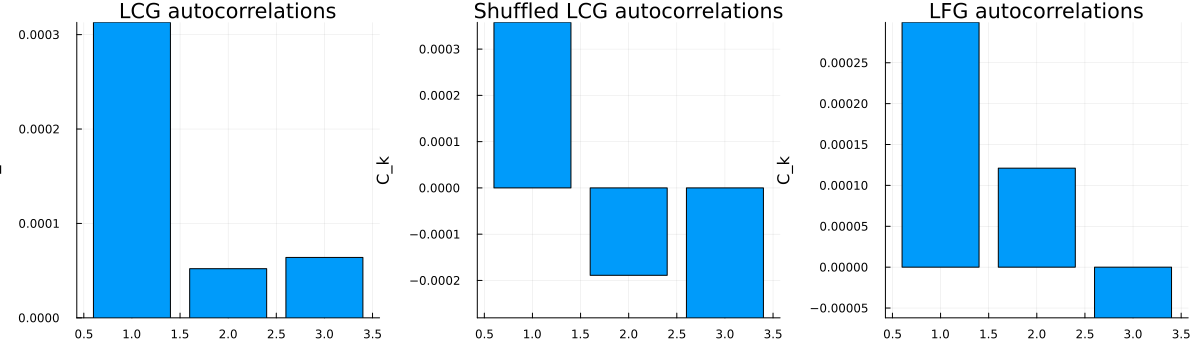

In [6]:
# Bar plots for autocorrelations C_k, k=1..3
cl = autocorrelations(lcg_vals)
cs = autocorrelations(shuf_vals)
cf = autocorrelations(lfg_vals)

p1 = bar(1:3, cl; xlabel="k", ylabel="C_k",
         title="LCG autocorrelations", legend=false)
p2 = bar(1:3, cs; xlabel="k", ylabel="C_k",
         title="Shuffled LCG autocorrelations", legend=false)
p3 = bar(1:3, cf; xlabel="k", ylabel="C_k",
         title="LFG autocorrelations", legend=false)

plot(p1, p2, p3; layout=(1,3), size=(1200, 350))

# Monte Carlo Integration: Full Theory and Motivation

Many problems in physics require evaluating integrals such as

$$
I = \int_a^b f(x)\,dx,
$$

or more generally $d$-dimensional integrals,

$$
I_d = \int_{\Omega \subset \mathbb{R}^d} f(\mathbf{x})\, d^d x.
$$

For 1D functions, classical numerical methods (Simpson’s rule, trapezoid, Gaussian quadrature) work very well.  
But in **high dimensions**, deterministic methods fail due to the *curse of dimensionality*:  
If each dimension is discretized with $n$ points, the total grid scales like $n^d$.

Monte Carlo avoids this: its error scales as $1/\sqrt{N}$ *independent of dimension*.  
This makes Monte Carlo indispensable in:

- Statistical mechanics (ensemble averages)
- Path integrals
- Lattice field theory
- Quantum many-body physics
- Bayesian inference / machine learning

Below is the full theoretical derivation.

---

## 1. Integral as an Expectation Value

Suppose $X$ is uniformly distributed on $[a,b]$.  
The PDF is

$$
p(x) = \frac{1}{b - a}, \quad a \le x \le b.
$$

The expectation of $f(X)$ is

$$
\mathbb{E}[f(X)] =
\int_a^b f(x)\, p(x)\, dx
=
\frac{1}{b-a} \int_a^b f(x)\, dx.
$$

Rearranging:

$$
\int_a^b f(x)\, dx = (b-a)\, \mathbb{E}[f(X)].
$$

Thus the integral equals a constant times the expectation value of $f$ with respect to a uniform distribution.

---

## 2. Monte Carlo Estimator

Draw $N$ independent samples $X_1, \dots, X_N \sim U(a,b)$.

Define:

$$
\hat{I}_N = (b-a) \frac{1}{N} \sum_{i=1}^N f(X_i).
$$

### 2.1 Unbiasedness

$$
\mathbb{E}[\hat{I}_N]
= (b-a)\, \frac{1}{N}\sum_{i=1}^N \mathbb{E}[f(X_i)]
= (b-a)\, \mathbb{E}[f(X)]
= I.
$$

So Monte Carlo gives the correct integral *on average*.

---

## 3. Variance and Error Scaling

The variance of the sample mean is

$$
\mathrm{Var}\!\left[\frac{1}{N}\sum_{i=1}^N f(X_i)\right]
= \frac{\sigma^2}{N},
$$

where

$$
\sigma^2 = \mathrm{Var}[f(X)].
$$

Thus,

$$
\mathrm{std}(\hat{I}_N) = \frac{(b-a)\sigma}{\sqrt{N}}.
$$

This yields the famous Monte Carlo error law:

$$
\boxed{
\text{Monte Carlo error} \sim \mathcal{O}\left(N^{-1/2}\right)
}
$$

**Independent of dimension!**

This is why Monte Carlo is used for **high-dimensional** integrals.

---

## 4. Importance Sampling (General Monte Carlo)

Uniform sampling is often inefficient, especially when:

- $f(x)$ is sharply peaked
- Most contribution comes from a small region of the domain

Instead, choose a **probability density $p(x)$** that resembles $|f(x)|$.

We rewrite:

$$
I = \int_{\Omega} f(x)\,dx
  = \int_{\Omega} \frac{f(x)}{p(x)} p(x)\,dx
  = \mathbb{E}_{p}\!\left[\frac{f(X)}{p(X)}\right].
$$

Thus the estimator is:

$$
\hat{I}_N = \frac{1}{N} \sum_{i=1}^N \frac{f(X_i)}{p(X_i)},
\qquad
X_i \sim p(x).
$$

### 4.1 Variance formula

$$
\mathrm{Var}_p\!\left[\frac{f(X)}{p(X)}\right]
= \int_{\Omega} \frac{f(x)^2}{p(x)}\,dx - I^2.
$$

The **optimal** (but usually unknown) choice is

$$
p_{\text{opt}}(x) \propto |f(x)|.
$$

Importance sampling dramatically improves convergence when $p(x)$ “matches” the structure of $f(x)$.

---

## 5. Example: Using an Exponential Distribution

Suppose we want to compute:

$$
I = \int_0^\infty g(z)\,dz.
$$

Choose the exponential distribution:

$$
g_0(z) = e^{-z}, \qquad z \ge 0,
$$

which is already normalized.

We rewrite:

$$
I = \int_0^\infty g(z)\,dz
  = \int_0^\infty \frac{g(z)}{g_0(z)} g_0(z)\,dz
  = \mathbb{E}_{g_0}\!\left[\frac{g(Z)}{g_0(Z)}\right].
$$

Thus the estimator is:

$$
\hat{I}_N = \frac{1}{N} \sum_{i=1}^N \frac{g(Z_i)}{g_0(Z_i)},
\qquad
Z_i \sim g_0(z).
$$

### 5.1 Sampling exponential random variables

If $U \sim U(0,1)$, then

$$
Z = -\ln(1-U)
$$

has PDF $e^{-z}$.  
(In practice, we often use $Z = -\ln U$.)

---

## 6. Why Monte Carlo is Crucial in Physics

Monte Carlo becomes essential in physics because:

### ✔ High–dimensional integrals  
Quantum field theory path integrals, partition functions, and integrals over phase space are often $10^5$–dimensional.

### ✔ Complex domains  
Constraints, boundaries, and discontinuous integrands make standard quadrature impossible.

### ✔ Natural statistical interpretation  
Many physical quantities *are* expectation values:

$$
\langle \mathcal{O} \rangle
= \frac{1}{Z} \int \mathcal{O}(x) e^{-\beta H(x)}\, dx.
$$

Monte Carlo directly approximates such expectations.

### ✔ Universal error scaling  
The $1/\sqrt{N}$ behavior allows simple control over statistical error.

Because of these features, Monte Carlo methods appear across:

- Quantum Monte Carlo  
- Markov Chain Monte Carlo  
- Lattice gauge theory  
- Density functional sampling  
- Statistical mechanics (Ising, XY, Potts)  
- Bayesian inference and machine learning  

---

## 7. Final Summary

Monte Carlo integration is based on three key ideas:

1. **Rewrite integrals as expectation values:**

   $$
   I = \mathbb{E}_p\!\left[\frac{f(X)}{p(X)}\right].
   $$

2. **Sample random variables from an appropriate PDF $p(x)$.**

3. **Estimate the result via sample average:**

   $$
   \hat{I}_N = \frac{1}{N} \sum_{i=1}^N \frac{f(X_i)}{p(X_i)}.
   $$

Choosing a good proposal distribution $p(x)$ is the heart of efficient Monte Carlo.

Monte Carlo is powerful because its error depends only on the number of samples and **not on dimensionality**, making it the standard tool in modern physics for evaluating integrals that are otherwise impossible.

In [7]:
# Define the integrand functions and proposal density
g1(x) = sin(x)^2 / (x * sinh(x))
g2(x) = sin(x) / (x * cosh(x))
g0(x) = exp(-x)  # proposal distribution

# Monte Carlo estimator using importance sampling with exponential proposal
function mc_integral(f, N::Int)
    r = lfg_sequence(N)          # use LFG for high-quality uniforms
    z = -log.(1 .- r)            # transform to exponential via inverse CDF
    w = f.(z) ./ g0.(z)          # weights g(z)/g0(z)
    return mean(w)
end

println("I1 ≈ ", mc_integral(g1, 200_000))
println("I2 ≈ ", mc_integral(g2, 200_000))

I1 ≈ 1.2253453326489907
I2 ≈ 1.1607749662858926


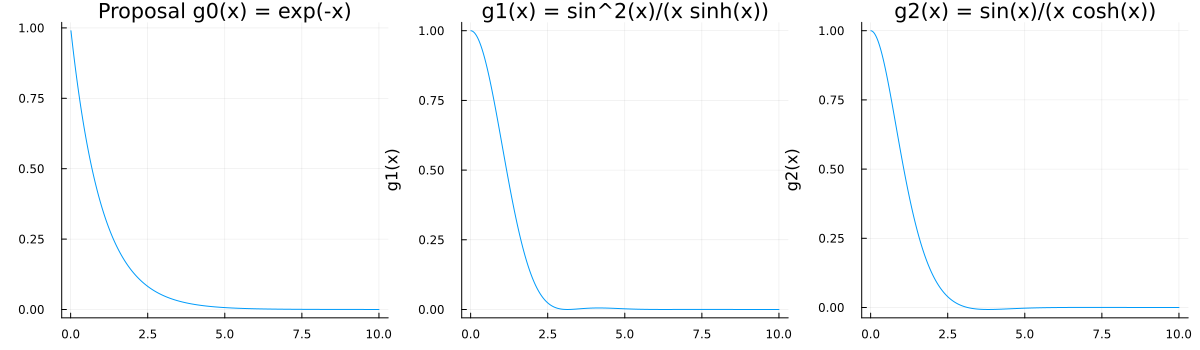

In [8]:
using Plots

g1(x) = sin(x)^2 / (x * sinh(x))
g2(x) = sin(x) / (x * cosh(x))
g0(x) = exp(-x)

xs = range(0.01, 10.0; length=1000)  # avoid x=0

p1 = plot(xs, g0.(xs),
          xlabel="x", ylabel="value",
          title="Proposal g0(x) = exp(-x)",
          legend=false)

p2 = plot(xs, g1.(xs),
          xlabel="x", ylabel="g1(x)",
          title="g1(x) = sin^2(x)/(x sinh(x))",
          legend=false)

p3 = plot(xs, g2.(xs),
          xlabel="x", ylabel="g2(x)",
          title="g2(x) = sin(x)/(x cosh(x))",
          legend=false)

plot(p1, p2, p3; layout=(1,3), size=(1200, 350))

In [9]:
using Statistics

# naive uniform sampler on [0, L]
function mc_uniform(f, N::Int; L::Float64=10.0)
    x = rand(N) .* L  # U(0,L)
    vals = f.(x)
    return L * mean(vals)
end

mc_uniform (generic function with 1 method)

# Monte Carlo Importance Sampling and Visual Diagnostics

Let me give a simplified and repeated reasoning with visual representation of solving integral. Usually one is required to evaluate integrals of the form
$$
I = \int_0^\infty g(x)\, dx,
$$
where the integrand may be oscillatory, slowly decaying, or dominated by contributions from narrow regions of the domain. Standard quadrature methods typically fail in these cases, either because they require an impractically large number of grid points to resolve oscillations or because the effective domain of integration is infinite and must be truncated in an ad-hoc manner. Monte Carlo methods avoid these difficulties by interpreting integrals as expectation values. Once the integral is expressed in this probabilistic form, random sampling provides an unbiased estimator whose statistical error scales as $N^{-1/2}$, independent of the dimensionality or complexity of the integrand.

The functions of interest in this notebook,
$$
g_1(x) = \frac{\sin^2 x}{x \sinh x}, 
\qquad
g_2(x) = \frac{\sin x}{x \cosh x},
$$
exemplify typical integrands that arise in perturbation theory, thermal Green’s functions, and spectral representations of correlation functions. Both $g_1$ and $g_2$ decay approximately as $e^{-x}/x$ for large $x$ but exhibit nontrivial oscillatory structure for small and intermediate $x$. As a consequence, any method based on uniform sampling in a truncated domain $[0,L]$ suffers from two forms of inefficiency: the oscillatory structure generates large cancellation errors, and the heavy exponential tail demands excessively large cutoffs to avoid systematic bias. A more effective strategy is to employ **importance sampling**, choosing a probability density that matches the dominant asymptotic behavior of the integrand.

For these integrals, a natural choice of proposal distribution is the exponential density
$$
g_0(x) = e^{-x}, \qquad x \ge 0,
$$
which is normalized, strictly positive on the relevant domain, and analytically invertible. Writing the integral in the form
$$
I = \int_0^\infty g(x)\, dx 
  = \int_0^\infty \frac{g(x)}{g_0(x)}\, g_0(x)\, dx
  = \mathbb{E}_{g_0}\!\left[ \frac{g(X)}{g_0(X)} \right],
\quad X \sim g_0,
$$
shows immediately that $I$ can be approximated by the Monte Carlo estimator
$$
\hat{I}_N = \frac{1}{N} \sum_{i=1}^N \frac{g(X_i)}{g_0(X_i)}.
$$
Because $g_1(x)$ and $g_2(x)$ share the same exponential decay as $g_0(x)$, the factor $g(x)/g_0(x)$ is comparatively well-behaved. The exponential contributions cancel exactly, and the resulting weight function depends only on the oscillatory and algebraic structure of the integrand. This cancellation dramatically reduces the variance of the estimator and is precisely the mechanism through which importance sampling achieves superior performance relative to uniform sampling.

Sampling from $g_0$ is straightforward. If $U$ is a uniform random variable on $(0,1)$, then the inverse-CDF transformation
$$
X = -\ln(1-U)
$$
produces an exactly exponential distribution. In the present notebook, this transformation is applied to a sequence of uniform numbers generated by a lagged Fibonacci generator (LFG), which is known to possess good statistical properties and long periods, making it suitable for large-scale Monte Carlo computations.

To build intuition for how the algorithm behaves in practice, the notebook includes an animation that visualizes the sampling and convergence process. In the upper panel, the exponentially distributed samples $X_1,\dots,X_n$ are accumulated and displayed as a histogram, superimposed with the analytical density $g_0(x) = e^{-x}$. This visualization serves two purposes. First, it verifies that the random number generator combined with the inverse-CDF procedure reproduces the expected theoretical distribution. Second, it illustrates the essential idea of importance sampling: the algorithm naturally allocates most samples to regions where the integrand is non-negligible. In contrast to uniform sampling on $[0,L]$, where points are wasted in regions where $g(x)$ is essentially zero, importance sampling automatically concentrates sampling effort where it matters.

The lower panel of the animation shows the running estimate
$$
I_n = \frac{1}{n}\sum_{i=1}^n \frac{g(X_i)}{g_0(X_i)}
$$
as a function of sample size $n$. Initially, the estimate fluctuates significantly due to the finite-sample variance. As $n$ increases, fluctuations decay at the expected rate proportional to $n^{-1/2}$, and the estimate stabilizes around the true value. The animation makes the convergence process visually accessible: one can literally observe the law of large numbers in action. This type of convergence plot is also an important diagnostic for Monte Carlo work, indicating whether the variance is controlled, whether the choice of proposal distribution is effective, and whether the estimator appears unbiased.

A second diagnostic included in the notebook plots the functions $g_1(x)$, $g_2(x)$, the proposal density $g_0(x)$, and the associated weight functions
$$
w_1(x) = \frac{g_1(x)}{g_0(x)}, \qquad
w_2(x) = \frac{g_2(x)}{g_0(x)}.
$$
This comparison emphasizes why the exponential proposal is well suited for the problem. While $g_1$ and $g_2$ contain oscillatory factors and algebraic decay, the exponential parts cancel exactly in $w(x)$. As a result, $w(x)$ exhibits moderate fluctuations but no exponential growth, which would otherwise lead to intractably large variance. Examining these plots provides an immediate visual explanation of the variance-reduction mechanism that defines importance sampling.

Together, the animations and plots form a coherent diagnostic suite that is routinely used in research-level Monte Carlo studies. They verify correct sampling from the proposal distribution, illustrate the structure of the weighted integrand, and provide direct evidence of estimator convergence. Beyond numerical correctness, these visualizations help develop intuition for why the method works and why some proposal distributions perform better than others. In practical research settings—ranging from quantum Monte Carlo to Bayesian inference—the same principles underlie the design of efficient samplers and the analysis of their variance properties.

In [12]:
g1(x) = sin(x)^2 / (x * sinh(x))
g2(x) = sin(x) / (x * cosh(x))
g0(x) = exp(-x)

g0 (generic function with 1 method)

In [14]:
using Plots, Statistics
gr()

g1(x) = sin(x)^2 / (x * sinh(x))
g0(x) = exp(-x)

# Use built-in RNG; plug your lfg_sequence here if you like
function sample_exponential(N::Int)
    r = rand(N)             # replace with your lfg_sequence(N)
    return -log.(1 .- r)    # inverse-CDF for exp(−x)
end

# Importance-sampling estimator
function mc_importance_g1(N::Int)
    z = sample_exponential(N)
    w = g1.(z) ./ g0.(z)
    return mean(w)
end

mc_importance_g1 (generic function with 1 method)

In [15]:
N_ref = 2_000_000
I1_ref = mc_importance_g1(N_ref)
println("Reference I1 ≈ ", I1_ref)

Reference I1 ≈ 1.2251608342516298


┌ Info: Saved animation to /var/folders/bz/0w39_bmn0wv3fd8ymg_g7y_00000gn/T/jl_DwfqNWPg54.gif
└ @ Plots /Users/ajitkumarsorout/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/var/folders/bz/0w39_bmn0wv3fd8ymg_g7y_00000gn/T/jl_DwfqNWPg54.gif")
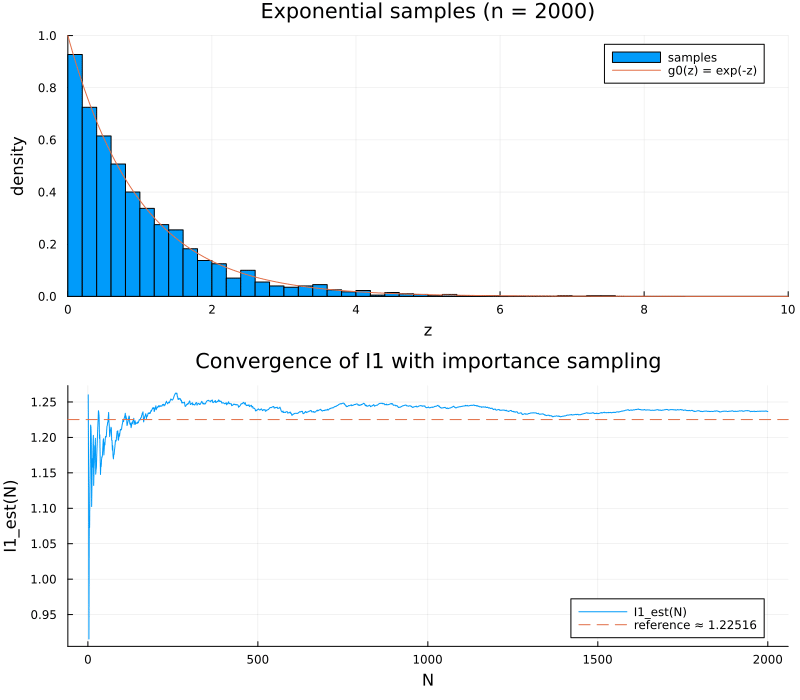

In [16]:
N_total = 200_000
z_all = sample_exponential(N_total)

xs = range(0, 10; length=300)

@gif for n in 2_000:2_000:N_total
    z = z_all[1:n]
    w = g1.(z) ./ g0.(z)
    I_est = mean(w)

    # --- Top panel: histogram of z vs exp(-z) ---
    p1 = histogram(z;
                   bins=50, normalize=true,
                   xlabel="z", ylabel="density",
                   title="Exponential samples (n = $n)",
                   label="samples", xlim=(0,10))

    plot!(p1, xs, g0.(xs); label="g0(z) = exp(-z)")

    # --- Bottom panel: running estimate vs N ---
    # we recompute estimates for all k up to n to make a curve
    Ns = 1:n
    z_partial = z_all[1:n]
    # cumulative running average
    w_all = g1.(z_partial) ./ g0.(z_partial)
    running_est = cumsum(w_all) ./ Ns

    p2 = plot(Ns, running_est;
              xlabel="N", ylabel="I1_est(N)",
              title="Convergence of I1 with importance sampling",
              label="I1_est(N)")

    hline!(p2, [I1_ref]; linestyle=:dash, label="reference ≈ $(round(I1_ref, digits=5))")

    plot(p1, p2; layout=(2,1), size=(800,700))
end every 1

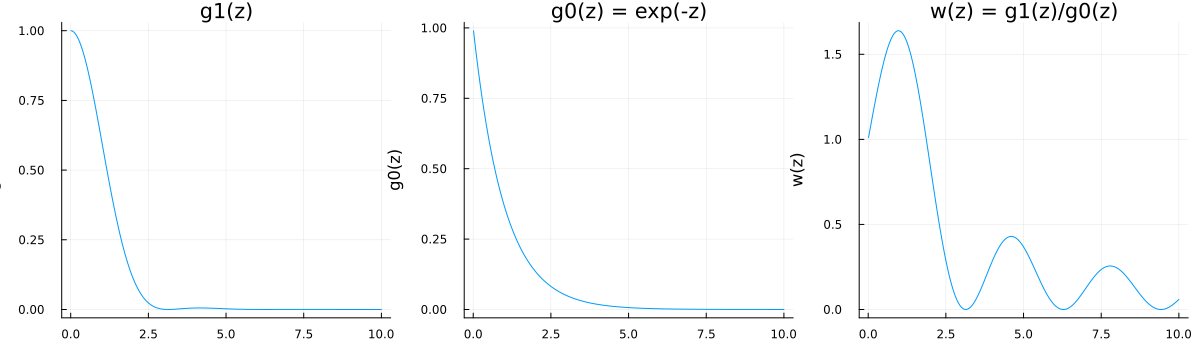

In [17]:
xs = range(0.01, 10; length=500)

p1 = plot(xs, g1.(xs);
          xlabel="z", ylabel="g1(z)",
          title="g1(z)",
          legend=false)

p2 = plot(xs, g0.(xs);
          xlabel="z", ylabel="g0(z)",
          title="g0(z) = exp(-z)",
          legend=false)

w1(z) = g1(z) / g0(z)
p3 = plot(xs, w1.(xs);
          xlabel="z", ylabel="w(z)",
          title="w(z) = g1(z)/g0(z)",
          legend=false)

plot(p1, p2, p3; layout=(1,3), size=(1200,350))